# Integration and label transfer with Tabula Muris

Following the general tutorial on atlas-level integration, here we show using scVI and scANVI for label transfer. In this setting we have:

1. Fully-labeled reference dataset
1. Unlabeled query dataset

We will demonstrate this functionality using Tabula Muris:

- Tabula Muris Consortium. "Single-cell transcriptomics of 20 mouse organs creates a Tabula Muris." Nature 562.7727 (2018): 367-372.

It is important to note that this tutorial covers *de novo* integration. With scvi-tools you can also perform online or sequential integration (i.e., *reference mapping*). Please see the scArches tutorial for more details.

In [1]:
%%capture
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "pymde"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


We supply Scanpy's read function with a backup url, which covers automatic data download.

In [3]:
dataset1 = sc.read(
    "data/TM_droplet.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_droplet_mat.h5ad",
)
dataset2 = sc.read(
    "data/TM_facs.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_facs_mat.h5ad",
)
dataset1.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_droplet_metadata.csv"
)
dataset2.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_facs_metadata.csv",
)

  0%|          | 0.00/236M [00:00<?, ?B/s]

  0%|          | 0.00/465M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We subset to labelled bone marrow cells because it is a reasonably sized dataset that will allow us to validate our method's ability to transfer labels from one dataset to another. In Tabula Muris, we are provided data collected using 10x Chromium, as well as SmartSeq2 data.

In [4]:
dataset1 = dataset1[
    (dataset1.obs.tissue == "Marrow") & (~dataset1.obs.cell_ontology_class.isna())
].copy()
dataset2 = dataset2[
    (dataset2.obs.tissue == "Marrow") & (~dataset2.obs.cell_ontology_class.isna())
].copy()

dataset1.obs["tech"] = "10x"
dataset2.obs["tech"] = "SS2"

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
dataset1.shape, dataset2.shape

((3652, 23433), (5037, 23433))

## Dataset preprocessing

### Normalize Smartseq2 matrix by gene length

We apply gene-length normalization because the number of reads representing a transcript is proportional to the lenght of the transcript, unless UMIs are used (as in 10x). A discussion of this phenomenon can be found in this 2017 [paper](https://europepmc.org/article/med/28529717) by Phipson B. 
Other than the gene length normalization, no other normalization is needed. scVI or scANVI is designed to handle sequencing depth and does not need cell-wise normalization. Normalizing and scaling the data will be detrimental to the performance of scVI and scANVI since they model explicitly the count data. 

The gene length file here is computed by taking the average length of alal transcripts corresponding to a mouse gene recorded in the ensembl dataabase. 

In [6]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


In [7]:
gene_len = gene_len.reindex(dataset2.var.index).dropna()
dataset2 = dataset2[:, gene_len.index]
assert (dataset2.var.index == gene_len.index).sum() == dataset2.shape[1]
dataset2.X = dataset2.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
dataset2.X = np.rint(dataset2.X)

### Dataset concatenation and gene selection
Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate for large gene sets in terms of runtime, we usually recommend filtering genes for best performance when the dataset has few number of cells. As a rule of thumb, performance starts to decrease when number of cells and number of genes are comparable. This point is emphasized in this [comparative analysis](https://doi.org/10.1101/2020.05.22.111161) of data integration algorithms for scRNA-seq data.

We perform this gene selection using the Scanpy pipeline while keeping the raw data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections via the Scanpy function. 

In [8]:
adata = dataset1.concatenate(dataset2)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata, 
    flavor="seurat_v3", 
    n_top_genes=2000, 
    layer="counts", 
    batch_key="tech",
    subset=True
)

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

* Register the AnnData object with the correct key to identify the sample.
* Create an SCVI model object.

In [9]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")

In [10]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

Now we train scVI. This should take a couple of minutes on a Colab session

In [11]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [04:29<00:00,  1.48it/s, loss=1.49e+03, v_num=1]


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [12]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

Finally, we visualize the learned scVI embeddings.

In [14]:
from scvi.model.utils import mde
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'channel' as categorical
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mouse.id' as categorical
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categ

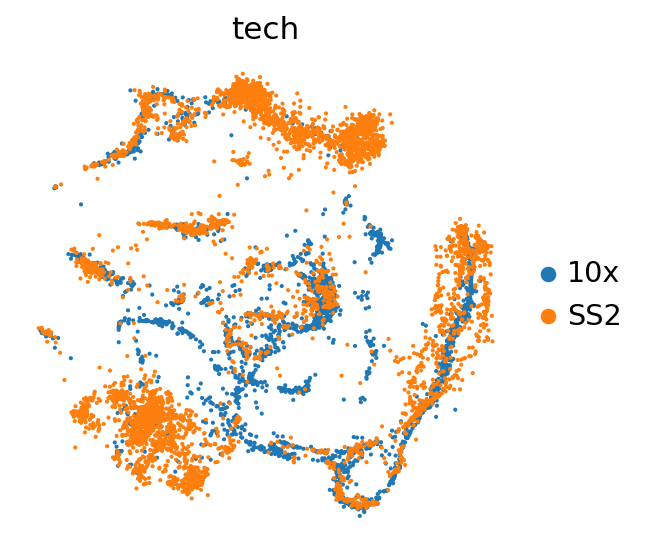

In [15]:
sc.pl.embedding(
    adata,
    basis="X_mde", 
    color=["tech"], 
    frameon=False, 
    ncols=1, 
)

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well. 

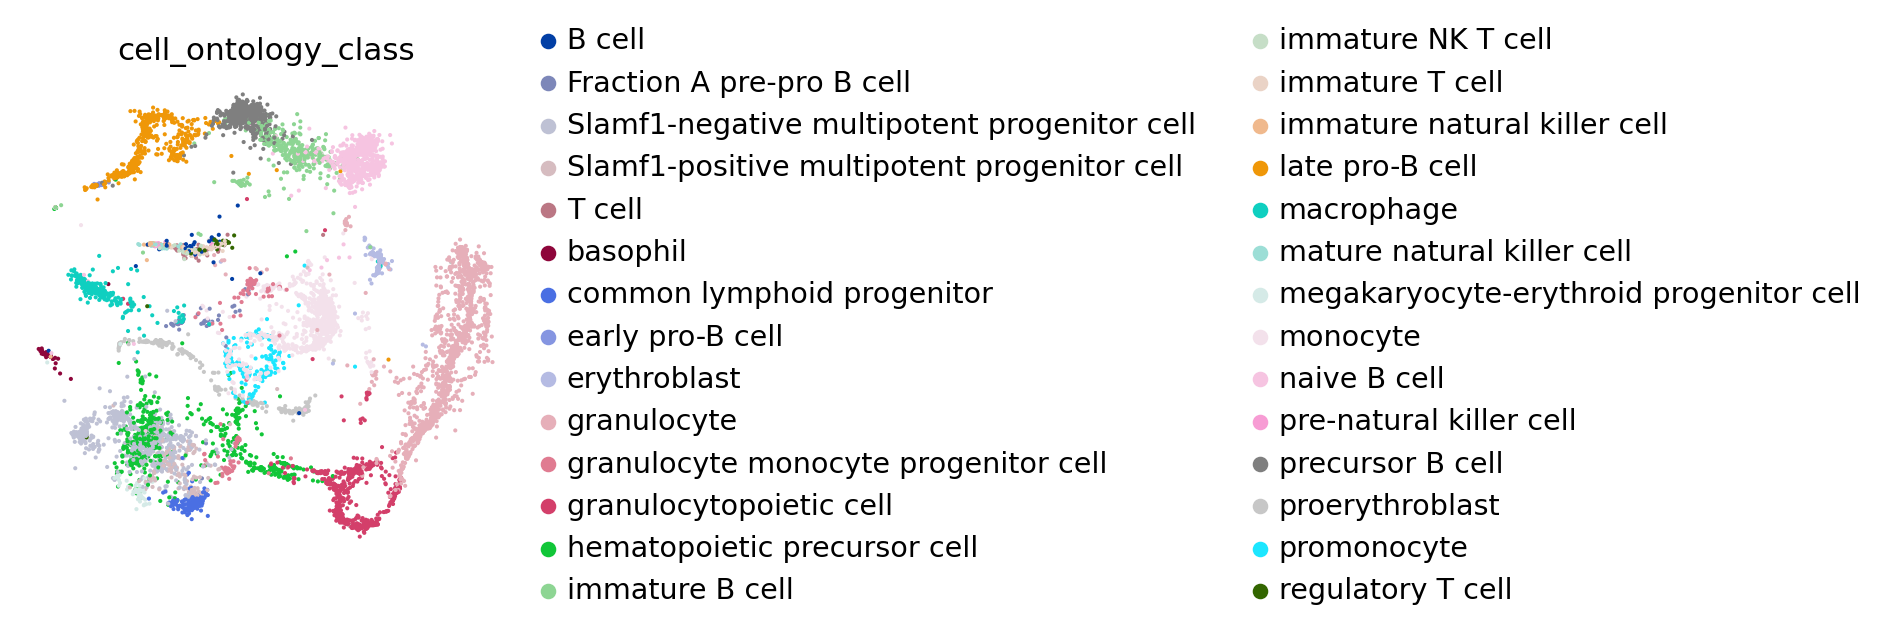

In [16]:
sc.pl.embedding(adata, color="cell_ontology_class", frameon=False, basis="X_mde")

From a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. A more refined analysis may be done at the level of markers.

## Transfer of annotations with scANVI

With scVI alone, we can train a classifier (e.g., [`RandomForestClassifer`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) on the latent representation of the labeled data and then obtain predictions for the query data. For example, we can imagine the 10x data is unannotated and then proceed to transfer labels using the latent reprsentation of the SS2 data.

We can also try to obtain a better latent representation/predictions by using the labels to inform the latent space. This is where scANVI comes in. scANVI uses semi-supervised learning to improve the model learned with scVI, allowing us to transfer our cell type knowledge from the reference to the query data. For this, we simply need to indicate to scANVI:

* the sample identifier for each cell (as in scVI), which in this case is the technology (10x vs SS2)
* the cell type, or an unnassigned label for each cell


#### scANVI labels

We assume that the SS2 data is annotated and the 10X data is not. Only the labels of the cells from the labelled SS2 dataset will be kept in the `adata.obs` column `'celltype_scanvi'`. All the 10X cells will have `'celltype_scanvi'` of value 'Unknown'. 

In [17]:
adata.obs["celltype_scanvi"] = 'Unknown'
ss2_mask = adata.obs['tech'] == "SS2"
adata.obs["celltype_scanvi"][ss2_mask] = adata.obs.cell_ontology_class[ss2_mask].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
np.unique(adata.obs["celltype_scanvi"], return_counts = True)

(array(['B cell', 'Slamf1-negative multipotent progenitor cell',
        'Slamf1-positive multipotent progenitor cell', 'Unknown',
        'basophil', 'common lymphoid progenitor', 'granulocyte',
        'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
        'hematopoietic precursor cell', 'immature B cell',
        'immature NK T cell', 'immature T cell',
        'immature natural killer cell', 'late pro-B cell', 'macrophage',
        'mature natural killer cell',
        'megakaryocyte-erythroid progenitor cell', 'monocyte',
        'naive B cell', 'pre-natural killer cell', 'precursor B cell',
        'regulatory T cell'], dtype=object),
 array([  44,  713,  134, 3652,   25,  156,  761,  134,  221,  265,  344,
          37,   60,   36,  306,  173,   49,   55,  266,  692,   22,  517,
          27]))

Since we've already trained an scVI model on our data, we will use it as a pretrained model to scANVI. 

In [19]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae, 
    adata=adata,
    unlabeled_category="Unknown",
    labels_key="celltype_scanvi", 
)

/usr/local/lib/python3.7/dist-packages/scvi/model/_scanvi.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels == self.unlabeled_category_
/usr/local/lib/python3.7/dist-packages/scvi/model/_scanvi.py:255: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self._labeled_indices = np.argwhere(labels != self.unlabeled_category_).ravel()


In [20]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it, loss=1.6e+03, v_num=1]


Now we can predict the missing cell types, and get the latent space

In [21]:
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

Again, we may visualize the latent space as well as the inferred labels

In [22]:
adata.obsm["X_mde_scanvi"] = mde(adata.obsm["X_scANVI"])

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_scanvi' as categorical


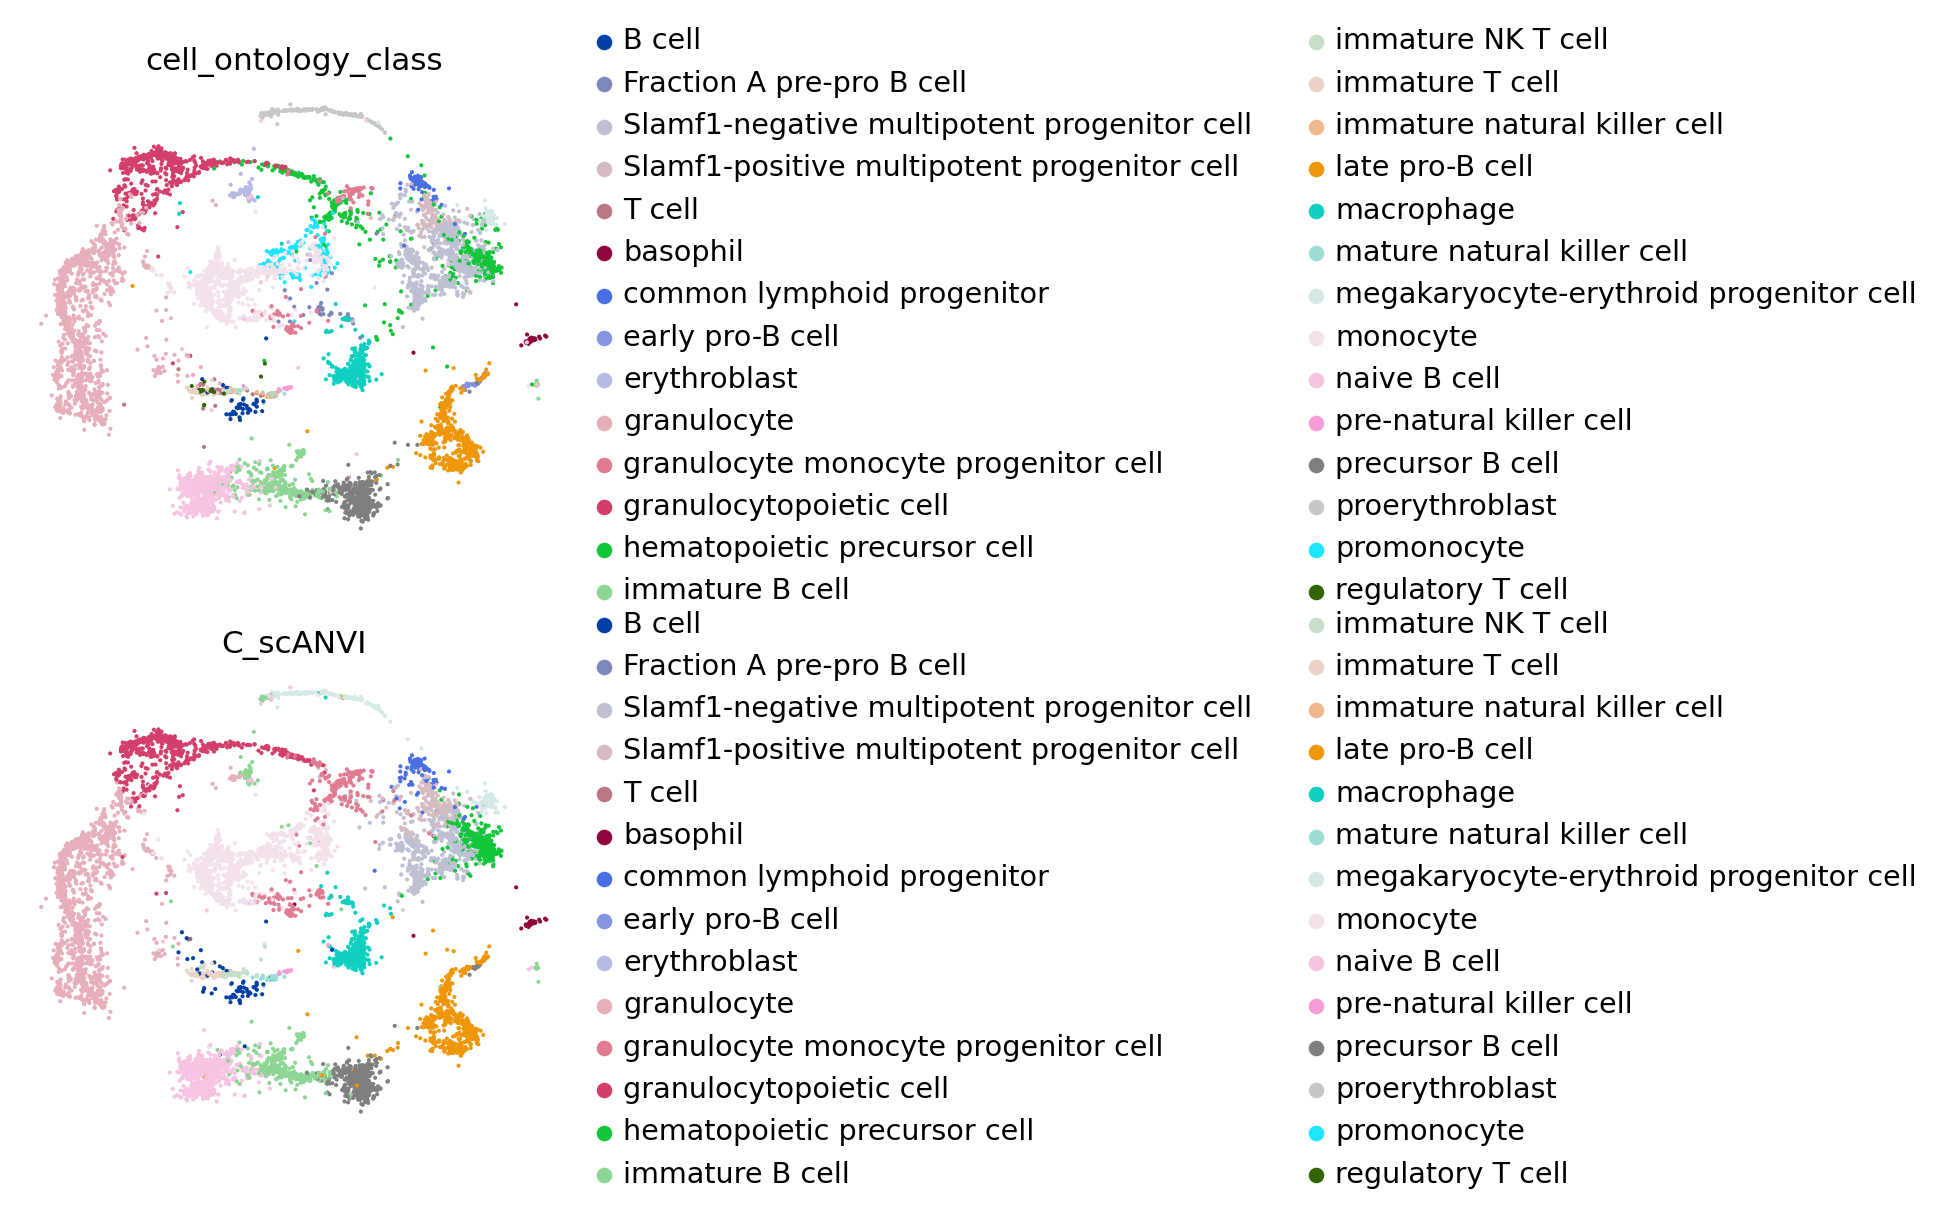

In [23]:
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
    adata.obs.C_scANVI.values, 
    categories=adata.obs.cell_ontology_class.cat.categories
)
sc.pl.embedding(
    adata,
    basis="X_mde_scanvi",
    color=[
           "cell_ontology_class", 
           "C_scANVI"
    ], 
    ncols=1, 
    frameon=False,
    palette=adata.uns["cell_ontology_class_colors"],
)

Now we can observe scANVI's performance using a confusion matrix.

In [24]:
df = adata.obs.groupby(["cell_ontology_class", "C_scANVI"]).size().unstack(fill_value=0)

In [32]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

Text(0, 0.5, 'Observed')

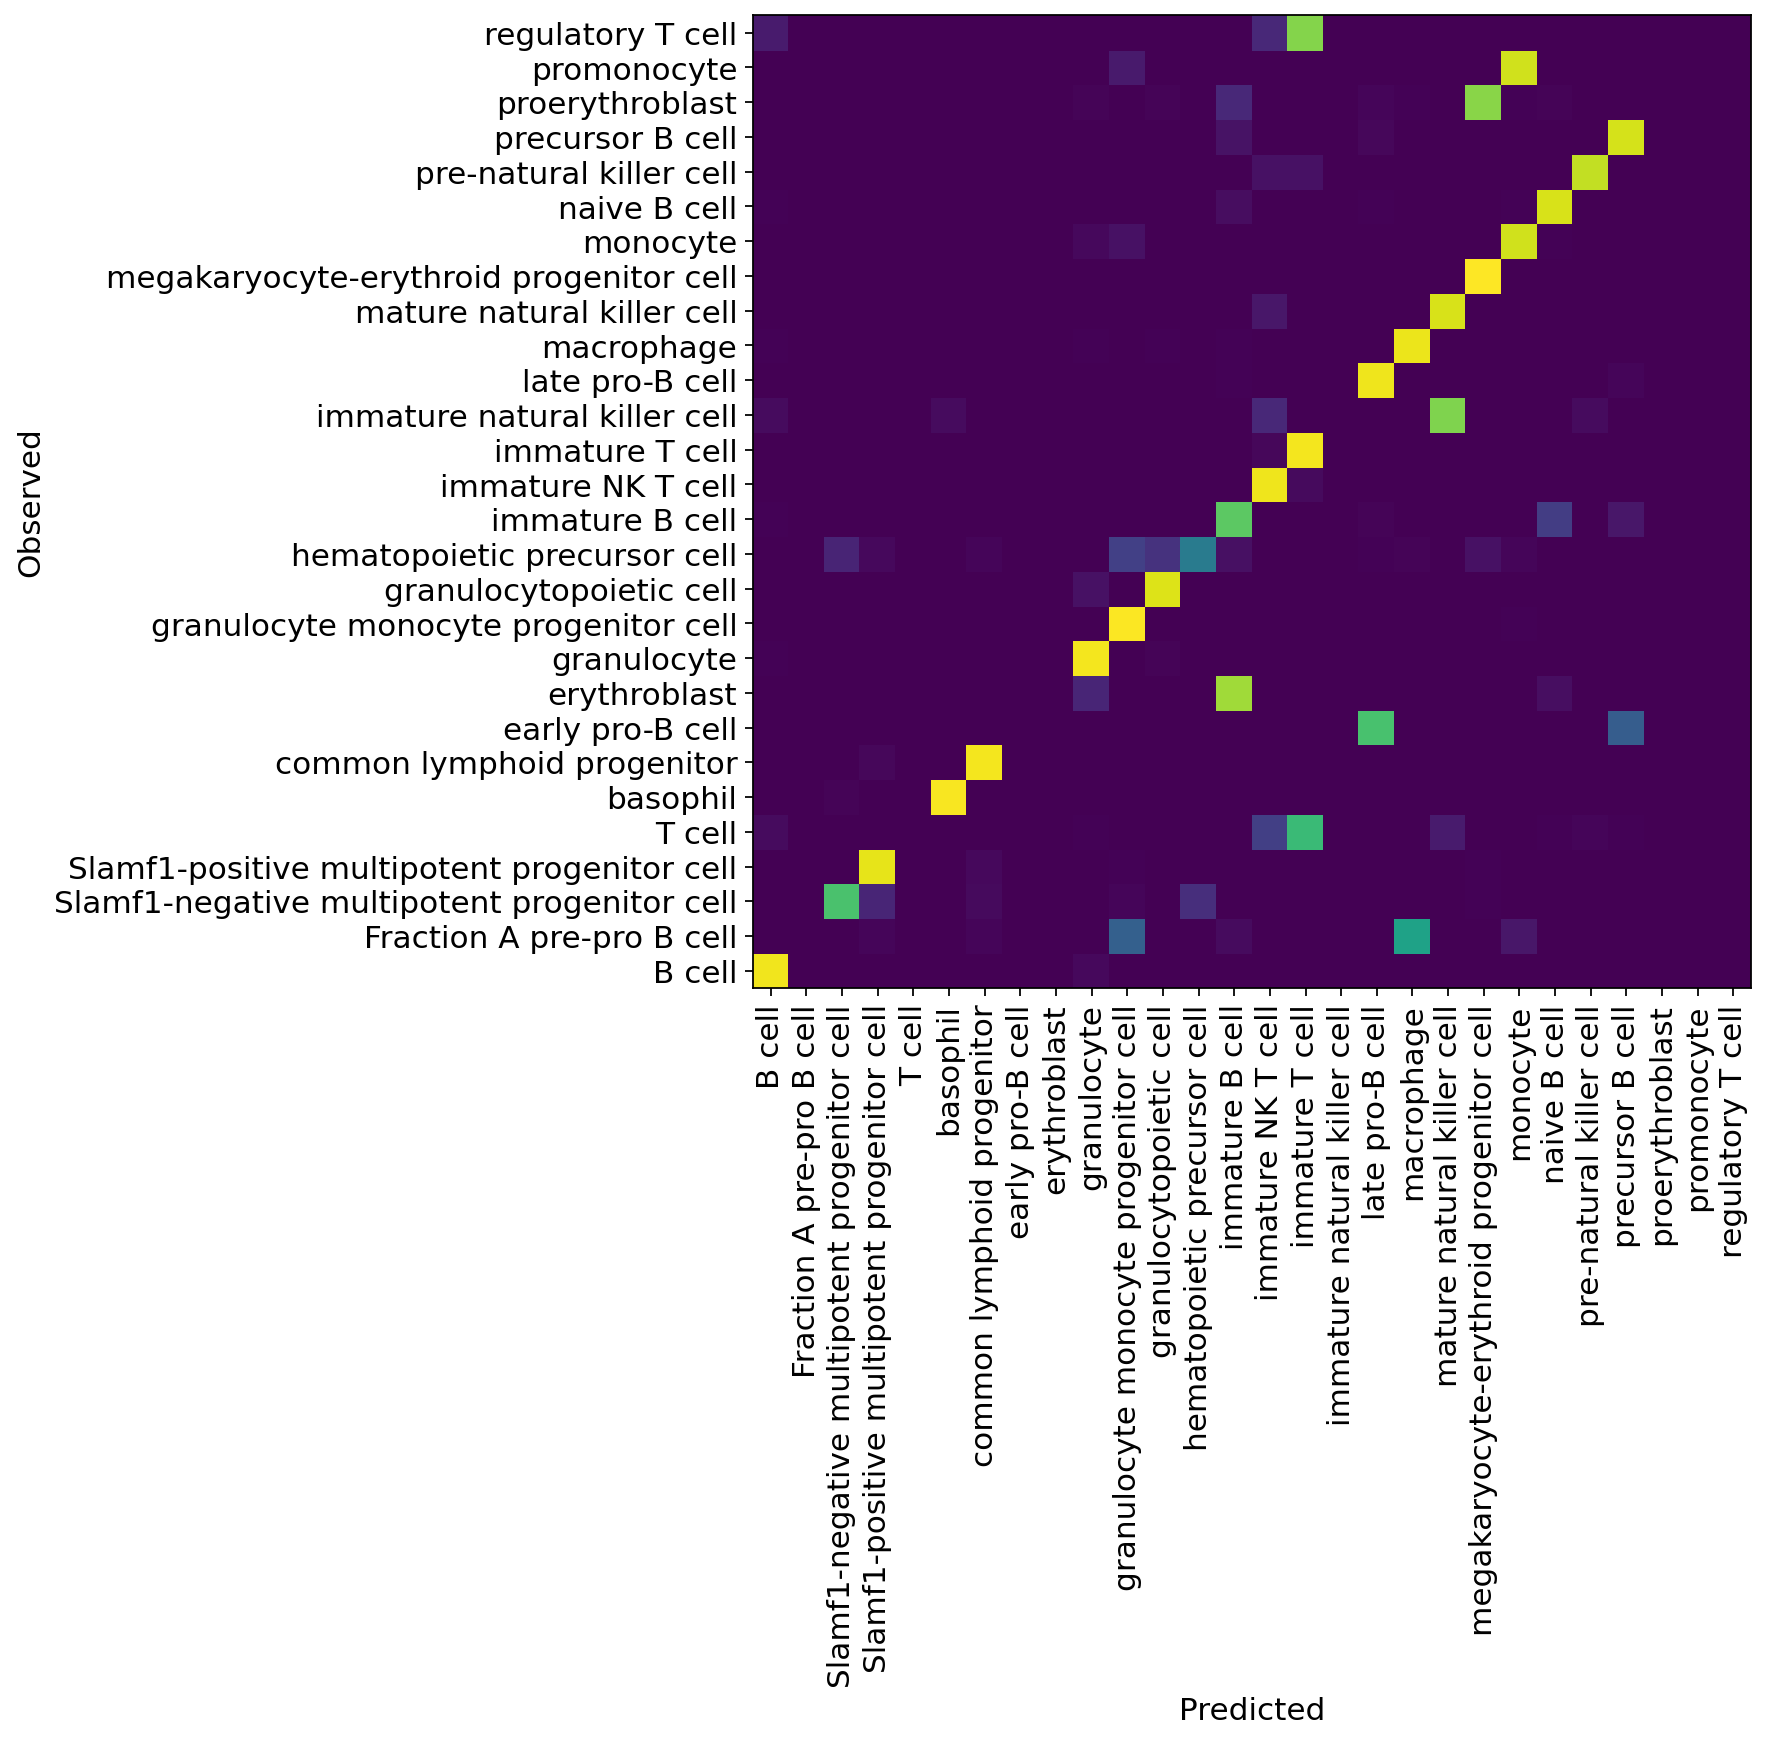

In [37]:
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

As we see in this, scANVI's latent space separates all cell types and performs well at classifying major cell types. Since the 10X data is labelled at lower resolution, the transferred labels are not always identical with the original label. However, biologically, the transferred labels are subsets of the original labels. 